In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#import os
#import zipfile
#unzip_dataset
#local_zip='/content/corn-or-maize-leaf-disease-dataset.zip'
#zip_ref=zipfile.ZipFile(local_zip,'r')
#zip_ref.extractall('/content/drive/MyDrive')

In [5]:
def print_in_color(txt_msg,fore_tupple=(100,40,40),back_tupple=(235,235,235)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [6]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,BatchNormalization 
from tensorflow.keras.layers import Activation,Conv2D, MaxPooling2D,Concatenate, AveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax

from tensorflow.keras.applications.resnet import ResNet101
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
import time
from tqdm import tqdm
from sklearn.metrics import f1_score

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


In [7]:
def make_dataframes(train_dir,val_dir, test_dir):
    bad_images=[]
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir,  val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir,  test_dir]
        names=['train', 'test'] 
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )       
        for klass in classlist:
            classpath=os.path.join(d, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                try:
                    img=cv2.imread(fpath)
                    shape=img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            if test_dir == None and val_dir == None:
                pdf=df
                train_df, dummy_df=train_test_split(pdf, train_size=.8,
                                                    shuffle=True, random_state=42, stratify=pdf['labels'])
                valid_df, test_df=train_test_split(dummy_df, train_size=.8,
                                                   shuffle=True, random_state=42, stratify=dummy_df['labels'])
            elif test_dir == None:
                pdf=df
                train_df,test_df=train_test_split(pdf, train_size=.8,
                                                  shuffle=True, random_state=123, stratify=pdf['labels'])
            else : # create a  validation dataframe
                pdf=df
                train_df,valid_df=train_test_split(pdf, train_size=.8,
                                                   shuffle=True, random_state=123, stratify=pdf['labels'])
    class_names=sorted(train_df['labels'].unique())
    class_count=len(class_names)
    sample_df=train_df.sample(n=100, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print()
    print('The names of the classes: ' , class_names)
    print()
    print('number of classes in processed dataset= ', class_count)  
    print()  
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print()
    print('train_df length: ', len(train_df),  '  valid_df length: ', len(valid_df),'  test_df length: ', len(test_df))  
    print()
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)


    return train_df, valid_df, test_df, class_names, class_count
# # if there is no test directory set test_dir = None, a test_df dataframe will be created from train_df
# test_dir = r'/content/drive/MyDrive/Dog and Cat/dev/valid'
# # if there is no validation directory set val_dir = None, a valid_df dataframe will be created from train_df
# val_dir= None
# train_dir= r'/content/drive/MyDrive/Dog and Cat/dev/train'


# or
 # if there is no test directory set test_dir = None, a test_df dataframe will be created from train_df
test_dir = None
 # if there is no validation directory set val_dir = None, a valid_df dataframe will be created from train_df
val_dir= None
train_dir= r'/content/drive/MyDrive/data'


train_df, valid_df,test_df , class_names, class_count=make_dataframes(train_dir,val_dir, test_dir)

train -Healthy                  : 100%|████████████████████████████████████████████████████| 1162/1162 [00:21<00:00, 54.77files/s]



The names of the classes:  ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

number of classes in processed dataset=  4

the maximum files in any class in train_df is  1045   the minimum files in any class in train_df is  459

train_df length:  3350   valid_df length:  670   test_df length:  168

average image height=  277   average image width=  268  aspect ratio h/w=  1.0335820895522387


In [8]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=225
min_samples=120
column='labels'
train_df, classes, class_count = trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  3350  with  4  classes
after trimming, the maximum samples in any class is now  225  and the minimum samples in any class is  120
the trimmed dataframe now is of length  900  with  4  classes


In [9]:
def balance(df, n,column, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')            # directory to store augmented images
    if os.path.isdir(aug_dir):                          # start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)                              # make class directories within aug directory

# create and store the augmented images  

    total=0
    gen=ImageDataGenerator(horizontal_flip=True,
                           rotation_range=15,
                           width_shift_range=.2,
                           height_shift_range=.2,
                           zoom_range=.2)
    
    groups=df.groupby(column)                           # group by class
    for label in df[column].unique():                   # for every class               
        group=groups.get_group(label)                   # a dataframe holding only rows with the specified label 
        sample_count=len(group)                         # determine how many samples there are in this class  
        if sample_count< n:                             # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count                      # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)     # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')                    # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,
                                            x_col='filepaths',
                                            y_col=None,
                                            target_size=img_size,
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False, 
                                            save_to_dir=target_dir,
                                            save_prefix='aug-',
                                            color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)

    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=440
# m= 450
column='labels'
working_dir=r'./'
img_size=(224,224)    
train_df=balance(train_df, n,column, working_dir, img_size)
# valid_df=balance(valid_df, m ,column, working_dir, img_size)

Initial length of dataframe is  900
Found 225 validated image filenames.
Found 225 validated image filenames.
Found 225 validated image filenames.
Found 225 validated image filenames.
Total Augmented images created=  860
Length of augmented dataframe is now  1760


In [10]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import splitfolders
file_path='../content/drive/MyDrive/data'
splitted_folder='../content/drive/MyDrive'
def train_test_valid(train_size=0.6,test_size=0.2,val_size=0.2,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  val_size = val_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(input_folder,output_folder, seed = 1337, ratio = (train_size,test_size,val_size), group_prefix = None)
train_test_valid()

Copying files: 4188 files [40:25,  1.73 files/s]


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_file_path = '../content/drive/MyDrive/train'
test_file_path =  '../content/drive/MyDrive/test'
val_file_path =  '../content/drive/MyDrive/val'

def data_pre_processing(valid_split = 0,input_size = (224, 224),image_color = 'rgb',batch_size = 32,
                        shuffle=True):


    train_gen2=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split,fill_mode='nearest',rotation_range=40,horizontal_flip=True)

    validation_gen2=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split)

    test_gen2=ImageDataGenerator(rescale=1/255.0)

    train_data=train_gen2.flow_from_directory(directory=train_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    test_data=test_gen2.flow_from_directory(directory=test_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    valid_data=validation_gen2.flow_from_directory(directory=val_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    return train_data,test_data,valid_data

train,test,validation=data_pre_processing()

Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


In [13]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen =ImageDataGenerator(horizontal_flip=True)    
gen2=ImageDataGenerator()


train_gen = gen.flow_from_dataframe(train_df,
                                    x_col= 'filepaths',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(valid_df,
                                    x_col= 'filepaths',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filepaths',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 1760 validated image filenames belonging to 4 classes.
Found 670 validated image filenames belonging to 4 classes.
Found 168 validated image filenames belonging to 4 classes.
55


In [21]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'T_Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [14]:
def AlexNet(img_shape):
    
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)

    X_input = Input(img_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    X = Dense(5,activation='softmax',name = 'fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name='AlexNet')
    
    return model

In [15]:
def Alexnet():
    
    model = Sequential()
    inputShape = (224, 224, 3)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (224,224,3)
        chanDim = 1

## Layer 1
    model.add(Conv2D(96, strides = (4, 4), kernel_size = (11, 11), activation = "relu", 
                    kernel_initializer = "he_uniform", padding = "valid", input_shape = (224, 224, 3)))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
    model.add(BatchNormalization())

## Layer 2
    model.add(Conv2D(256, padding = "same", kernel_size = (5, 5), activation = "relu", 
                    kernel_initializer = "he_uniform"))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
    model.add(BatchNormalization())

## Layer 3
    model.add(Conv2D(384, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform", 
                    padding = "same"))
    model.add(BatchNormalization())

## Layer 5 
    model.add(Conv2D(384, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform", 
                    padding = "same"))
    model.add(BatchNormalization())

## Layer 6 
    model.add(Conv2D(256, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform", 
                    padding = "same"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (3, 3)))


## Flatten the Model and Connect it 
# To Connected Layer 
    model.add(Flatten())
    model.add(Dense(4096, activation = "relu", kernel_initializer = "he_uniform"))
    model.add(Dropout(0.3))

## Dense 2 
    model.add(Dense(1500, kernel_initializer = "he_uniform", activation = "relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

## Dense 3 
    model.add(Dense(1000, kernel_initializer = "he_uniform", activation = "relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

## Output Layer
    model.add(Dense(4, activation = "softmax", kernel_initializer = "glorot_uniform"))

    return model

In [16]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [17]:
base_model = Alexnet()

In [18]:
# img_size = (227, 227)
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)

In [19]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# base_model=tf.keras.applications.inception_v3.InceptionV3(include_top=False,
#                                                            weights="imagenet",
#                                                            input_shape=img_shape,
#                                                            pooling='max') 

model = Sequential([ base_model,
                     BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
                     Dense(1024, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                     bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
                     Dropout(rate= 0.4, seed= 123),
                     Dense(4, activation= 'softmax')
])

model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4)                 28193496  
                                                                 
 batch_normalization_6 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1024)              5120      
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 28,202,732
Trainable params: 28,195,484
Non-trainable params: 7,248
______________________________________

In [22]:
batch_size = 32           # set batch size for training
epochs = 40               # number of all epochs in training
patience = 2              #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 4         # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9           # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5            # factor to reduce lr by
ask_epoch = 5             # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [23]:
history = model.fit(x= train,
                    epochs= epochs,
                    verbose= 1,
                    callbacks= callbacks,
                    validation_data= validation,
                    validation_steps= None,
                    shuffle= True,
                    )

Do you want model asks you to halt the training [y/n] ?
n
 Epoch    T_Loss  Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/40
79/79 [==============================] - 68s 638ms/step - loss: 1.0625 - accuracy: 0.7320 - val_loss: 1.8885 - val_accuracy: 0.2775
Epoch 2/40
79/79 [==============================] - 47s 591ms/step - loss: 0.7670 - accuracy: 0.7861 - val_loss: 2.1029 - val_accuracy: 0.2943
Epoch 3/40
79/79 [==============================] - 53s 662ms/step - loss: 0.7463 - accuracy: 0.7758 - val_loss: 2.2049 - val_accuracy: 0.2823
Epoch 4/40
79/79 [==============================] - 46s 585ms/step - loss: 0.6688 - accuracy: 0.8005 - val_loss: 2.0622 - val_accuracy: 0.3900
Epoch 5/40
79/79 [==============================] - 48s 604ms/step - loss: 0.6237 - accuracy: 0.8076 - val_loss: 1.3253 - val_accuracy: 0.6352
Epoch 6/40
79/79 [==============================] - 47s 591ms/step - loss: 0.5801 - accuracy: 0.8124 - val_loss: 2.2330 - val_accuracy:

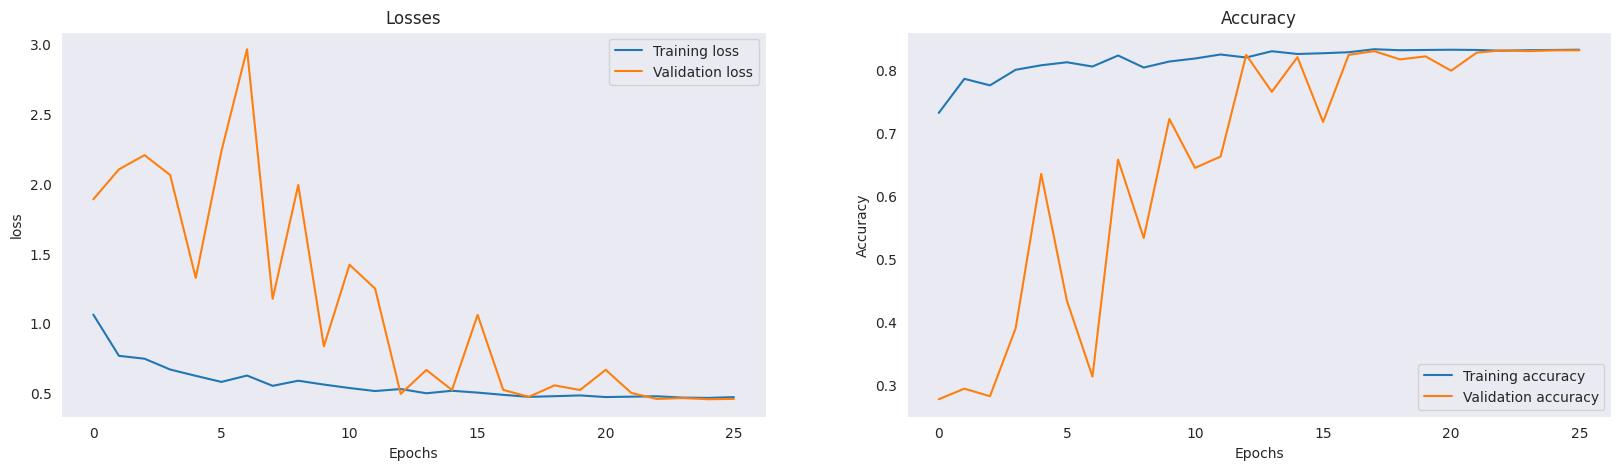

In [25]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()